# Calculate cross-corr coeff statistics

author: steeve.laquitaine@epfl.ch

Status: backlogged

install `requirements_kilosort_silico.txt`

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2

from time import time

import logging
import logging.config
import os

import numpy as np
import pandas as pd
import spikeinterface as si
import yaml
from spikeinterface import comparison, widgets

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

from src.nodes.utils import get_config_silico_neuropixels, write_metadata
from src.nodes.io.silico import loading_raw_recording

SIMULATION_DATE = "2023_02_19"

# get config
data_conf, param_conf = get_config_silico_neuropixels(SIMULATION_DATE).values()

# set Kilosort sorted spikes and cells path
KS3_SORTING_PATH = data_conf["sorting"]["sorters"]["kilosort3"]["output"]

# set ground truth spikes and cells path
GT_SORTING_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["output"]


# setup logging
with open("conf/logging.yml", "r", encoding="utf-8") as logging_conf:
    LOG_CONF = yaml.load(logging_conf, Loader=yaml.FullLoader)
logging.config.dictConfig(LOG_CONF)
logger = logging.getLogger("root")

In [29]:
def spikes_times_to_binary(spike_timepoints, sampling_freq:float, recording_duration:float):
    """convert spike timepoints to binary vectors
    
    note: 10,000 Hz sampling frequency creates a timepoint every 0.1 ms.
    Bin duration is 0.1 ms.

    Args:
        spike_timepoints (_type_): _description_
        sampling_freq (float): _description_
        recording_duration (float): _description_

    Returns:
        _type_: _description_
    """
    timepoints_sec = 1/sampling_freq
    n_timepoints = int(np.ceil(recording_duration)/timepoints_sec)

    # create binary spike train
    spike_train = np.zeros((1, n_timepoints), dtype=np.int8)
    spike_train[:, spike_timepoints] = 1
    return spike_train

def get_cells_binary(SortingExtractorKS3, sampling_freq:float, duration:float):
    """convert all cells spike timepoints to binary vectors

    Args:
        SortingExtractorKS3 (_type_): _description_
        sampling_freq (float): _description_
        duration (float): recording duration

    Returns:
        _type_: _description_
    """
    spike_train_dict = dict()
    units = SortingExtractorKS3.unit_ids
    for u_i in units:
        spike_timepoints = SortingExtractorKS3.get_unit_spike_train(unit_id=u_i)
        spike_train = spikes_times_to_binary(spike_timepoints, sampling_freq, duration)
        spike_train_dict[u_i] = spike_train
    return spike_train_dict

def bin_spike_train(spike_train:np.array, bin_size:int):
    """bin spike train

    Args:
        spike_train (np.array): _description_
        bin_size (int): _description_
    
    Usage:
        spike_train = np.array([0,0,0,1,0,0,0,0,1,0,0,0])
        bin_size = 4
        binned_spike_train = bin_spike_train(spike_train, bin_size)

    Returns:
        _type_: _description_
    """
    n_timepoints = len(spike_train)
    bin_size = 4
    new_n_timepoints = int(n_timepoints/bin_size)
    binned = np.reshape(spike_train,(new_n_timepoints, bin_size)).sum(axis=1)
    
    # sanity-check
    assert all(binned<=1), "there must at most one spike per bin to satisfy refractory period, reduce bin size"
    return binned 


def get_crosscorr(unit_spike_train:np.array, true_spike_train:np.array):
    """calculate cross-correlation (not normalized)

    note: 
    - both should have the same length
    - the formula is not taken from the book "Analysis of parallel spike train" 
    which divides the result by the number of time bins but 
    from the conventional definition of cross-correlation. It also makes sense
    as to calculate the coefficient it is compared with the expected match count
    in case of independence - two counts are thus compared.
    With this definition, the cross correlation coeff match the one given by
    numpy.corrcoef.
    
    Args:
        unit_spike_train (np.array): _description_
        true_spike_train (np.array): _description_
    
    Returns:
        : z-scored cross-correlation coefficient
    """
    return np.dot(true_spike_train, unit_spike_train)


def get_cross_corr_coeff(unit_spike_train:np.array, true_spike_train:np.array):
    """calculate cross-correlation (not normalized)

    note: both should have the same length
    
    Args:
        unit_spike_train (np.array): _description_
        true_spike_train (np.array): _description_
    
    Returns:
        : z-scored cross-correlation coefficient
    """
    n_bins = len(unit_spike_train)
    n_true_spikes = sum(unit_spike_train)
    n_sorted_spikes = sum(true_spike_train)

    cross_corr = get_crosscorr(unit_spike_train, true_spike_train)

    # calculate expected matches in case of independence
    # expected_match = p_true(spike=1) x p_sorted(spike=1) x n_bins
    null_expected_match = n_true_spikes * n_sorted_spikes / n_bins
    denominator = np.sqrt((n_true_spikes - (n_true_spikes**2)/n_bins) * (n_sorted_spikes - (n_sorted_spikes**2)/n_bins))
    return (cross_corr - null_expected_match) / denominator

def get_cross_corr_coeff_std(n_true_spikes, n_sorted_spikes, n_bins):
    component_2 = (n_true_spikes * n_sorted_spikes) / (n_bins**2)
    return np.sqrt( (1/n_bins) * (1 - component_2))


def get_zcccoeff(unit_spike_train:np.array, true_spike_train:np.array):
    """_summary_

    note: both should have the same length. This holds for all firing rates.
    
    Args:
        unit_spike_train (np.array): _description_
        true_spike_train (np.array): _description_
    
    Returns:
        (float): z-scored cross-correlation coefficient
    """
    # count spies and bins
    n_true_spikes = sum(unit_spike_train)
    n_sorted_spikes = sum(true_spike_train)
    n_bins = len(unit_spike_train)

    # calculate cross-correlation
    crosscorr = get_crosscorr(unit_spike_train, true_spike_train)

    # calculate expected number of matches in case of independence
    # expected_match = p_true(spike=1) x p_sorted(spike=1) x n_bins
    null_expected_match_count = (n_true_spikes * n_sorted_spikes) / n_bins

    # z-score the cross-correlation under the assumption
    # that the probability of observing a spike within a bin
    # is given by a Poisson process.
    return (crosscorr - null_expected_match_count) / np.sqrt(null_expected_match_count)


def get_cross_corr_coeff_stats(true_spike_train:np.array, sorted_spike_train:np.array, bin_size:int):
    """_summary_

    Args:
        true_cell (int): _description_
        sorted_cell (int): _description_
    
    Usage:

    """
    # bin spike trains
    t0 = time()
    binned_sorted = bin_spike_train(true_spike_train, bin_size=bin_size)
    print(time()-t0)
    t0 = time()
    binned_true = bin_spike_train(sorted_spike_train, bin_size=bin_size)
    print(time()-t0)

    # calculate cross correlation coefficient statistics
    # assuming that spikes are generated in each bin by a Poisson process
    t0 = time()
    cross_corr_coeff = get_cross_corr_coeff(binned_sorted, binned_true)
    print(time()-t0)
    t0 = time()
    std_of_cross_corr_coeff = get_cross_corr_coeff_std(sum(binned_sorted), sum(binned_true), len(binned_sorted))
    print(time()-t0)
    t0 = time()
    zscore = get_zcccoeff(binned_sorted, binned_true)
    print(time()-t0)
    return {
        "cross_corr_coeff": cross_corr_coeff, 
        "std_of_cross_corr_coeff": std_of_cross_corr_coeff, 
        "zscore": zscore
        }


def get_zscore(true_spike_train:np.array, sorted_spike_train:np.array, bin_size:int):
    """_summary_

    Args:
        true_cell (int): _description_
        sorted_cell (int): _description_
    
    Usage:

    """
    # bin spike trains
    binned_sorted = bin_spike_train(true_spike_train, bin_size=bin_size)
    binned_true = bin_spike_train(sorted_spike_train, bin_size=bin_size)

    # calculate cross correlation coefficient statistics
    # assuming that spikes are generated in each bin by a Poisson process
    zscore = get_zcccoeff(binned_sorted, binned_true)
    return {
        "zscore": zscore
        }

def compare_sorter_to_ground_truth_with_ccc(GTSortingExtractor, SortingExtractorKS3):
    pass

In [3]:
# load the raw lfp recording
trace = loading_raw_recording.load(data_conf)
duration = trace.get_total_duration()

# get spikes and their sampling frequency
SortingExtractorKS3 = si.load_extractor(KS3_SORTING_PATH)
GTSortingExtractor = si.load_extractor(GT_SORTING_PATH)
sampling_freq = int(GTSortingExtractor.get_sampling_frequency())

# get cells' spike vectors
sorted_spike_train = get_cells_binary(SortingExtractorKS3, sampling_freq, duration)
true_spike_train = get_cells_binary(GTSortingExtractor, sampling_freq, duration)

In [14]:
sorted_cell = 0
true_cell = 1981516
comparison_out = get_cross_corr_coeff_stats(sorted_spike_train[sorted_cell][0], true_spike_train[true_cell][0], 4)
comparison_out

0.05338597297668457
0.05256319046020508
0.20055484771728516
0.20034503936767578
0.21346139907836914


{'cross_corr_coeff': 0.005211187164009387,
 'std_of_cross_corr_coeff': 0.0008528017698274474,
 'zscore': 6.100788098659697}

In [30]:
sorted_cell = 0
true_cell = 1981516
t0 = time()
comparison_out = get_zscore(sorted_spike_train[sorted_cell][0], true_spike_train[true_cell][0],4)
print(time()-t0)
comparison_out

0.31975317001342773


{'zscore': 6.100788098659697}

In [35]:
# target
duration = 0.31
# duration = 0.001
303*530*duration/3600

13.828583333333334

In [99]:
# calculate for all cell pairs (would take 29 hours)
BIN_SIZE = 4
ccorr_coeffs_df = pd.DataFrame()
ccorr_coeffs_std_df = pd.DataFrame()
zscore_df = pd.DataFrame()

i=0
t0 = time()
for _, (s_i, s_spike_train_i) in enumerate(sorted_spike_train.items()):
    i+=1
    for _, (true_i, true_spike_train_i) in enumerate(true_spike_train.items()):
        out = get_cross_corr_coeff_stats(s_spike_train_i[0], true_spike_train_i[0], BIN_SIZE)
        ccorr_coeffs_df.loc[true_i,s_i] = out["cross_corr_coeff"]
        ccorr_coeffs_std_df.loc[true_i,s_i] = out["std_of_cross_corr_coeff"]
        zscore_df.loc[true_i,s_i] = out["zscore"]
    print(i, time()-t0)

ccorr_coeffs_df.to_parquet('/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study/cell_matching/ccc_matching.parquet')
ccorr_coeffs_std_df.to_parquet('/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study/cell_matching/ccc_std_matching.parquet')
zscore_df.to_parquet('/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study/cell_matching/zscore_matching.parquet')

# dataframe: sorted ids in columns, true in index

1 352.1945712566376
2 703.8615462779999
3 1057.7989702224731


KeyboardInterrupt: 

In [100]:
from joblib import Parallel, delayed
import multiprocessing
print("available cpu:", multiprocessing.cpu_count())

# get spike train data
sorteds = sorted_spike_train
trues = true_spike_train

# get cell ids
s_ids = sorteds.keys()
t_ids = trues.keys()

# calculate cccoeffs in parallel
t0=time()
out = Parallel(n_jobs=70)(delayed(get_cross_corr_coeff_stats)(sorteds[s_i][0], trues[t_i][0], BIN_SIZE) for s_i in s_ids for t_i in t_ids)
time()-t0

available cpu: 72


In [32]:
# MatchingObject = comparison.compare_sorter_to_ground_truth(
#     GTSortingExtractor, SortingExtractorKS3, exhaustive_gt=True
# )
# MatchingObject.agreement_scores

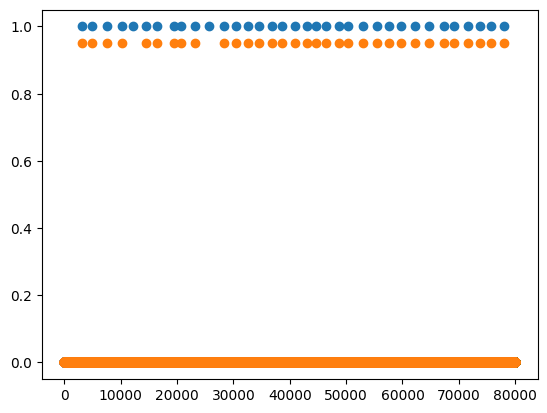

In [82]:
# sanity check the match with best agreement score
true_cell = 1981516
sorted_cell = 0
true_spike_train[true_cell], sorted_spike_train[sorted_cell]

from matplotlib import pyplot as plt
plt.plot(true_spike_train[true_cell][:,0:80000].T, "o", linestyle="None");
plt.plot(sorted_spike_train[sorted_cell][:,0:80000].T * 0.95, "o", linestyle="None");

In [12]:
cell_matching = pd.read_parquet(data_conf["postprocessing"]["cell_matching"])
cell_matching.sort_values(by="agreement_score", ascending=False)

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/env_kilosort_silico/lib/python3.9/site-packages/IPython/core/formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,sorted_cell,true_cell_match,oversplit_true_cell,agreement_score
0,0.0,1981516,True,0.430918
107,107.0,3972082,True,0.289256
302,302.0,355657,False,0.273292
38,37.0,1684667,True,0.154321
300,300.0,141668,False,0.150150
...,...,...,...,...
640,NaN,4046827,None,NaN
641,NaN,4138989,None,NaN
642,NaN,4063216,None,NaN
643,NaN,2623483,None,NaN


In [ ]:
# agreement score between sorted and true cells
MatchingObject = comparison.compare_sorter_to_ground_truth(
    GTSortingExtractor, SortingExtractorKS3, exhaustive_gt=True
)
MatchingObject = compare_sorter_to_ground_truth_with_zccc(
    GTSortingExtractor, SortingExtractorKS3, exhaustive_gt=True
)

# get true cell best matches based on max accuracy (Hungarian Method)
# cell_matching = MatchingObject.agreement_scores.idxmax().to_frame()
# cell_matching.columns = ["true_cell_match"]
# cell_matching.index.name = "sorted_cell"
# cell_matching = cell_matching.reset_index()